# Dissection of a Super Mario Bros Playing DQN (CNN)

## DQN Loading and Testing

In [1]:
# load dqn model and dataset
import dqn

model = dqn.load_dqn('resources/mario_net_86.chkpt', transform=False)
random_model = dqn.load_dqn('resources/mario_net_86.chkpt', transform=False, random=True)

from netdissect import parallelfolder, upsample, tally, pbar, imgviz, show
dataset = parallelfolder.ParallelImageFolders(['resources/dissect_images'],
                shuffle=True,
                classification=True,
                transform=dqn.transform_before_dqn)

In [2]:
# Other imports and config
import torch
from torchvision import transforms as T
from PIL import Image
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
import IPython
mpl.rcParams['lines.linewidth'] = 0.25
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.linewidth'] = 0.25

In [3]:
"""
A helper function that tells the predicted
action given the output of the DQN
"""
def action_from_dqn_output(out):
    SIMPLE_MOVEMENT = [
        ['NOOP'],
        ['right'],
        ['right', 'A'],
        ['right', 'B'],
        ['right', 'A', 'B'],
        ['A'],
        ['left'],
    ]
    idx = torch.argmax(out.to('cpu'))
    action = SIMPLE_MOVEMENT[idx]
    return '-'.join(action)

InstrumentedModel(
  (model): MarioNet1(
    (stack): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=3136, out_features=512, bias=True)
      (8): ReLU()
      (9): Linear(in_features=512, out_features=7, bias=True)
    )
  )
)


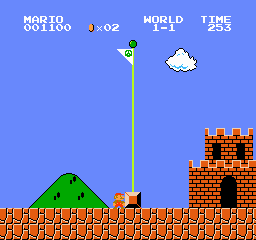

'right-A-B'

In [4]:
# test the model and the dataset
indices = [200, 755, 709, 423, 60, 100, 110, 120]
batch = torch.cat([dataset[i][0][None,...] for i in indices])

predicted_action = action_from_dqn_output(model(batch[2].cuda()))
test_image = Image.open(dataset.images[indices[2]][0])

print(model)
display(test_image, predicted_action)

About the dataset:

- `dataset[i][0]` contains the transformed representation of the image (`dataset.tranform(raw_image`)
- `dataset[i][1]` is 0
- `dataset.images[i][0]` is the path of the image
- `dataset.images[i][1]` is 0

The goal of this design is to keep compatible with the functions and classes provided by the code repo of the original netdissect paper.

## Test Semantic Segmentation of Super Mario Bros Game Scenes

In [5]:
# Load the segmentation model
from segmenter import load_segmodel, decode_segmap

segmodel = load_segmodel('resources/MarioSegmentationModel.pth')

/home/choutianxius/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/choutianxius/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# A helper function to visualize segmentations
def test_segment(path, show_orig=True, save=False, save_path=None):
    img = Image.open(path)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    if show_orig: ax1.imshow(img); ax1.axis('off'); ax1.set_title('Raw Image')

    segm = segmodel(img, numpy=True).squeeze(0)
    segm_rgb = decode_segmap(segm)
    ax2.imshow(segm_rgb); ax2.axis('off'); ax2.set_title('Segmentation Mask')
    plt.tight_layout()
    if save:
        plt.save(save_path)
    plt.show()

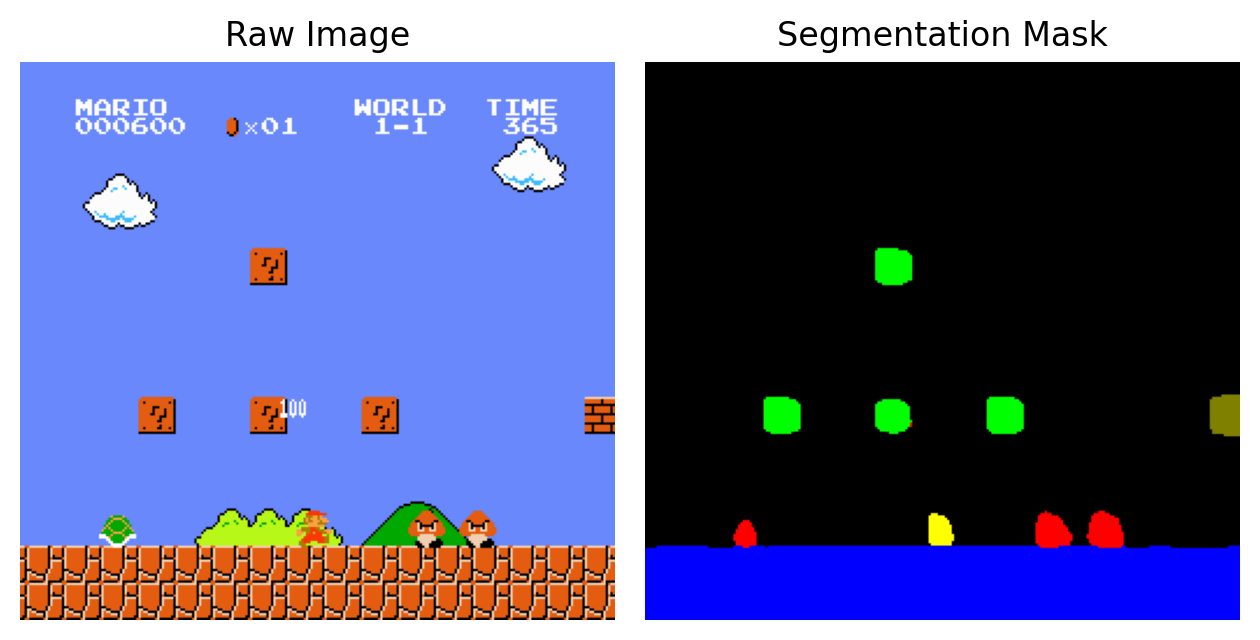

In [7]:
# Test it
test_segment(dataset.images[indices[0]][0])

## Visualize the Activation of a Single Unit

A convolutional unit works by iterating its input through sliding windows and putting the output of each sliding window at the corresponding position within the whole output.

![cnn-principle.gif from wikipedia](cnn-principle.gif)

(Illustration from [wikipedia](https://commons.wikimedia.org/wiki/File:Convolution_arithmetic_-_Full_padding_no_strides.gif))

As relu is applied after each convolutional layer, the numerical value at each point of the output of a convolutional unit represents the activation ability of the unit by the corresponding part in the input. By resizing the output through bilinear upsampling or downsampling, we can visualize how each pixel in the input image activates a convolutional unit.

In [8]:
"""
A helper function to visualize the activation of a unit,
highlight the most activated part, and show the original input alongside
"""
def viz_activation(model, layername, unit_idx, img_idx, quantile=0.95, path=None):
    # First, hook up a layer (retain)
    model.retain_layer(layername)
    # Feed the input into the model
    # and the activation of the hooked layer will be retained
    model(dataset[img_idx][0].cuda())
    # Fetch the activation of the retained layer
    acts = model.retained_layer(layername)
    # Select the activation of the given unit
    a = acts[0][unit_idx].unsqueeze(0)
    # Perform upsampling (default mode is bilinear)
    upsampled_a = T.Resize((240, 256), antialias=True)(a)[0]

    fig, (ax2, ax1, ax3) = plt.subplots(1, 3)
    ax1.imshow(upsampled_a.cpu()); ax1.axis('off'); ax1.set_title('Activation (Upsampled)')
    img = Image.open(dataset.images[img_idx][0])
    ax2.imshow(img); ax2.axis('off'); ax2.set_title('Raw Image')

    upsampled_a = upsampled_a.cpu()
    quantile_m = np.quantile(upsampled_a.numpy(), quantile)
    mask = np.ma.masked_where(upsampled_a.numpy() > quantile_m, upsampled_a)
    image_arr = np.array(img)
    masked = np.copy(image_arr)
    masked[mask.mask] = image_arr[mask.mask]
    masked[~mask.mask] = image_arr[~mask.mask] * 0.5 # darken less activated area

    title3 = f'Top {int(np.round((1-quantile)*100))}% Activated Area'
    ax3.imshow(masked); ax3.axis('off'); ax3.set_title(title3)

    layerindices = { 'stack.0': 1, 'stack.2': 2, 'stack.4': 3 }
    text = f'Unit {unit_idx} of Layer {layerindices[layername]}, Image {img_idx}'
    fig.text(0.5, 0.25, text, ha='center')
    plt.tight_layout()
    if path:
        plt.savefig(path, bbox_inches='tight')
    plt.show()

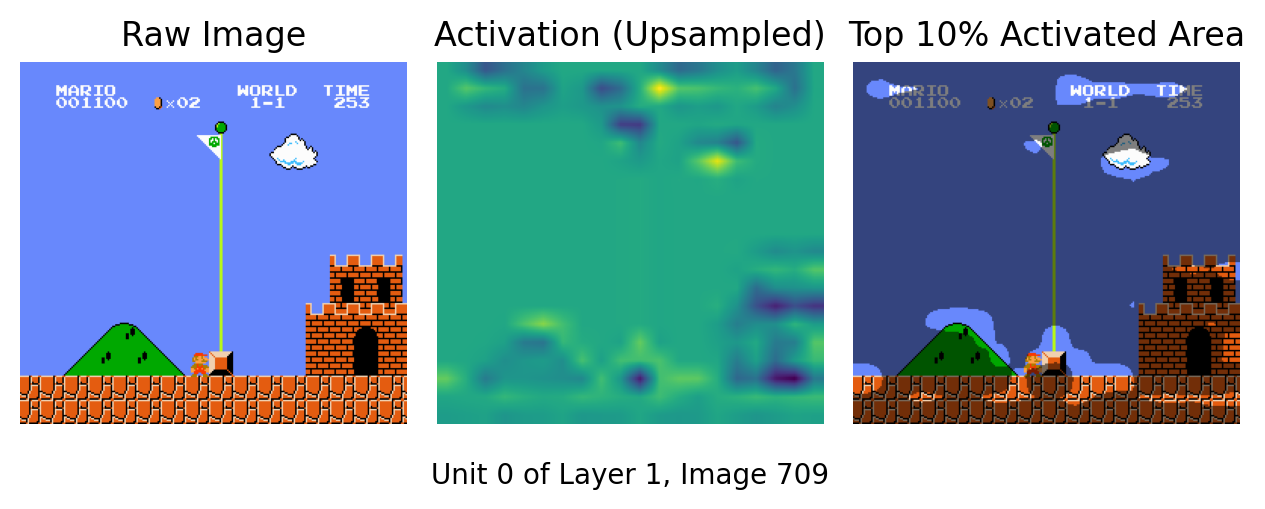

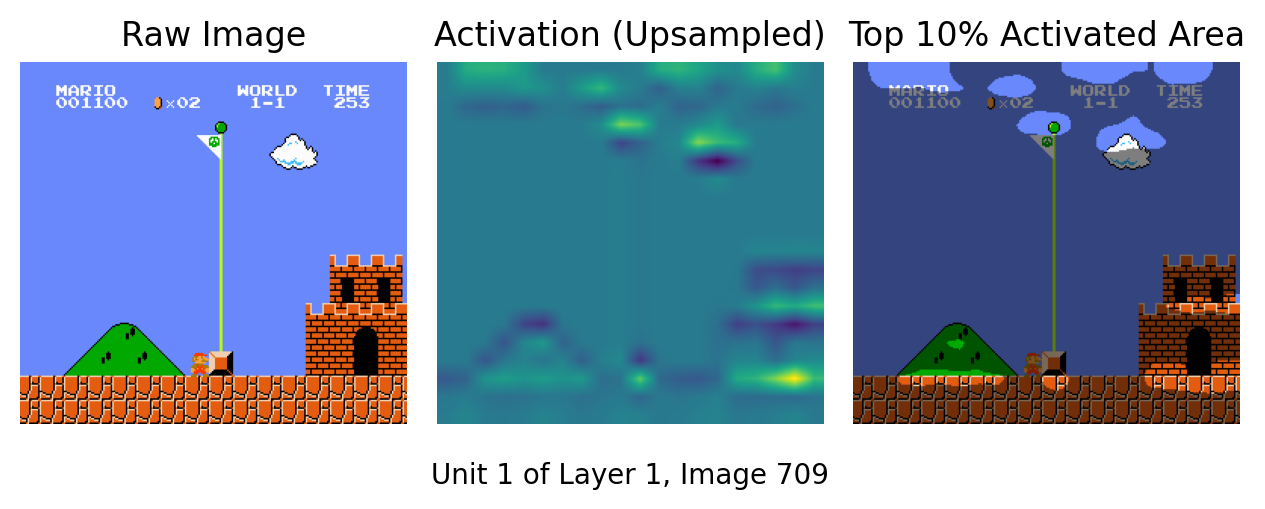

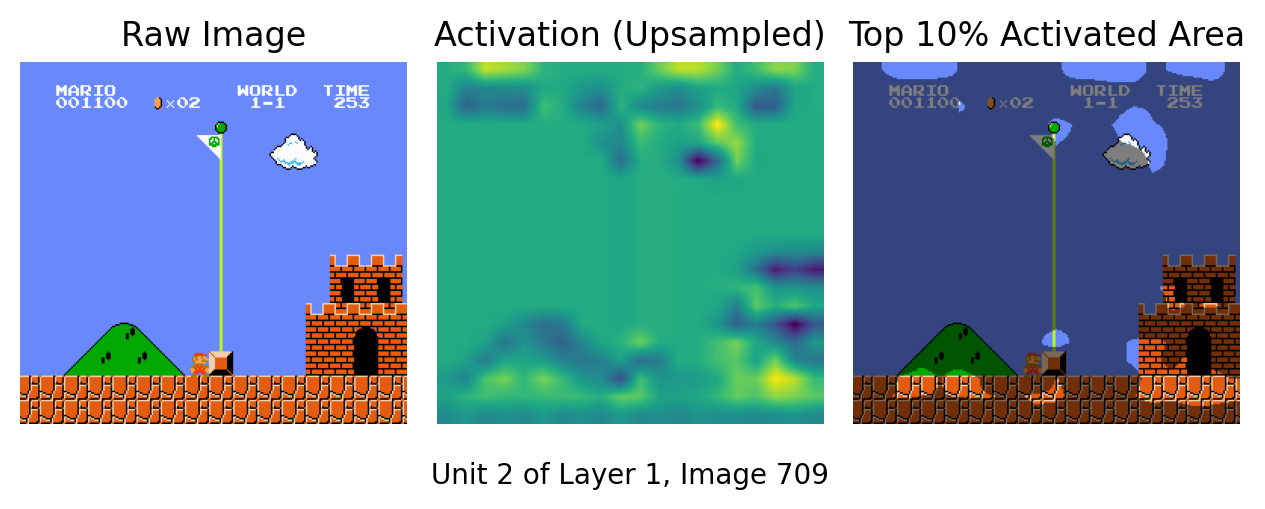

In [9]:
# Same image, different units
for unit_idx in range(3):
    viz_activation(model=model, layername='stack.0', unit_idx=unit_idx, img_idx=indices[2], quantile=0.90)

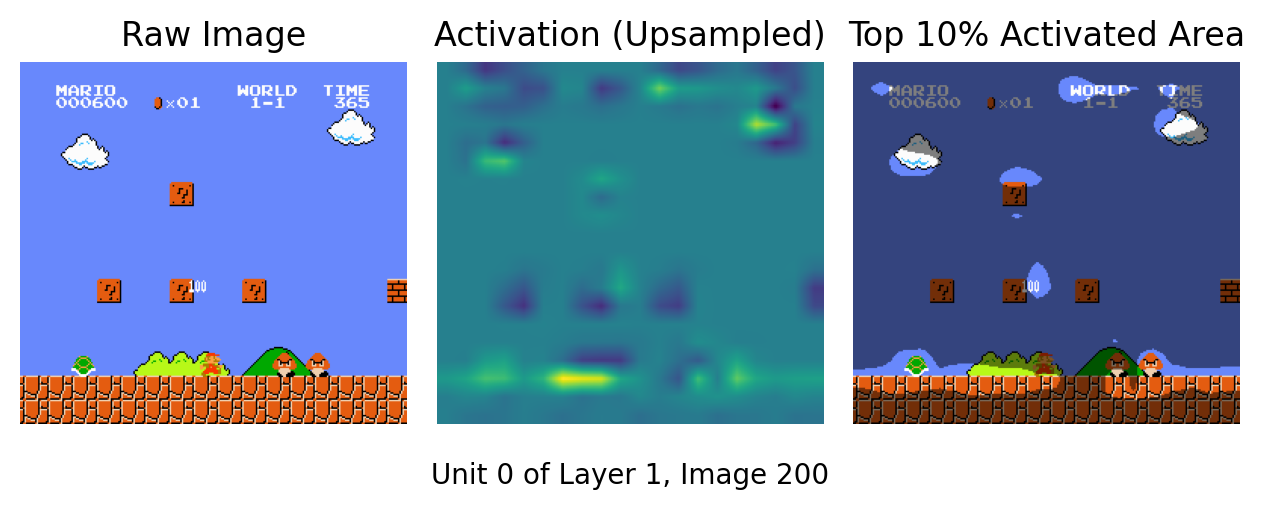

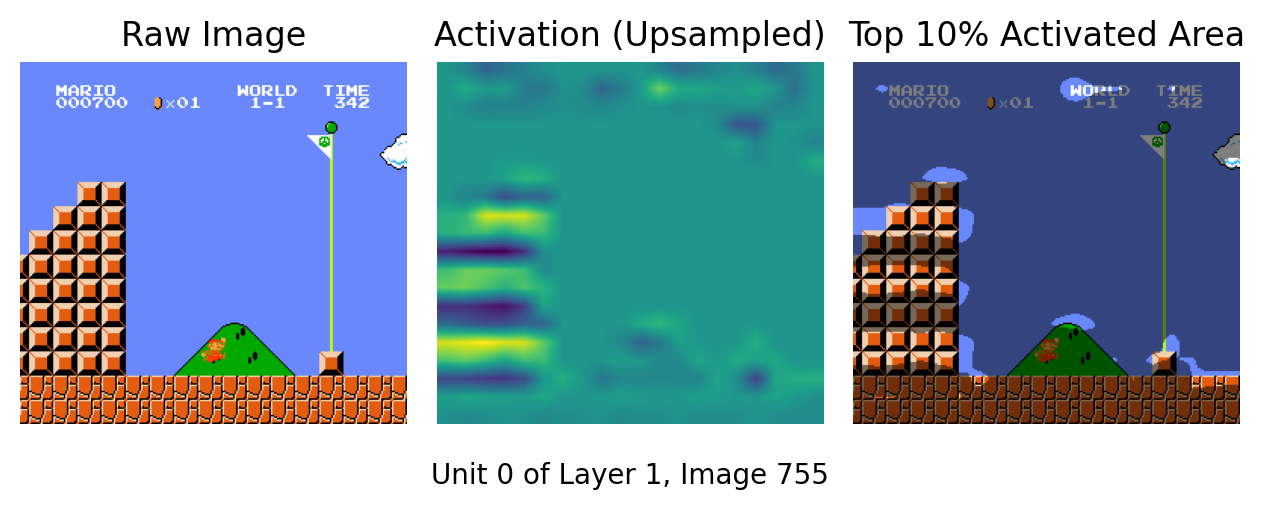

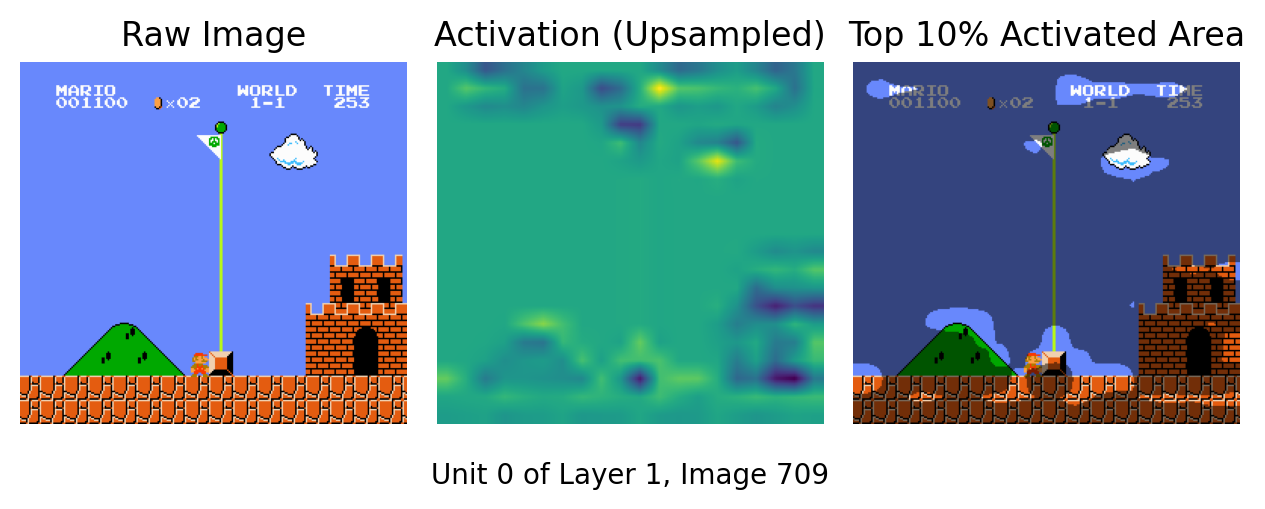

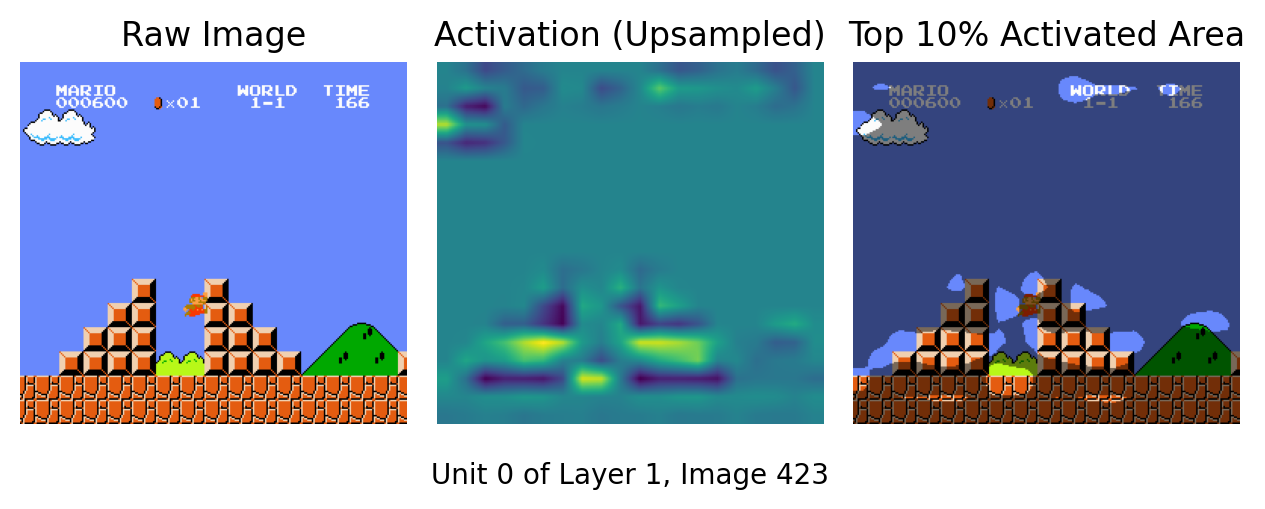

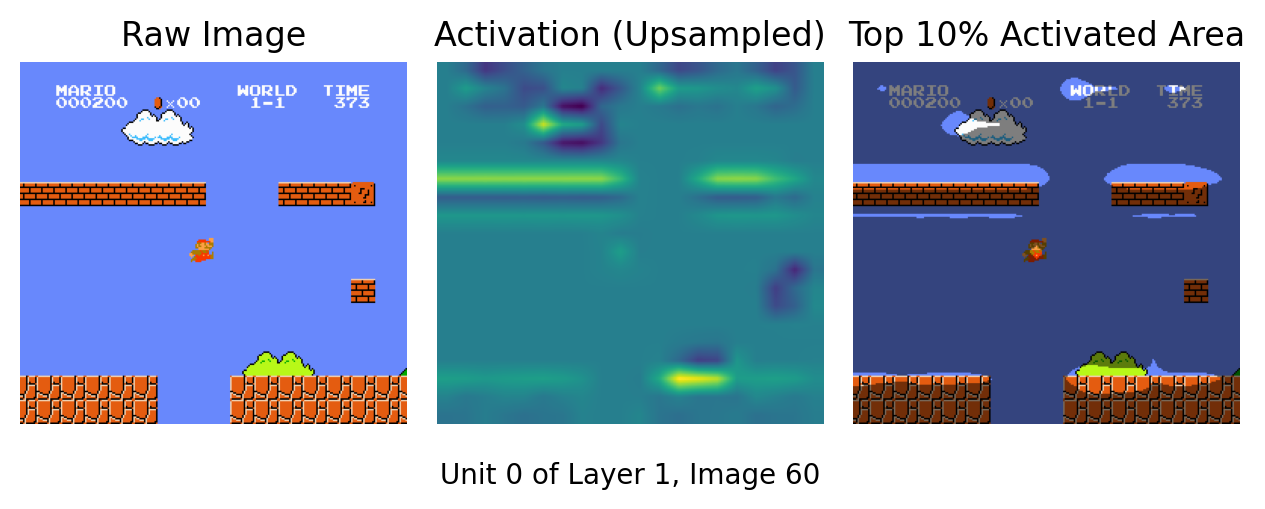

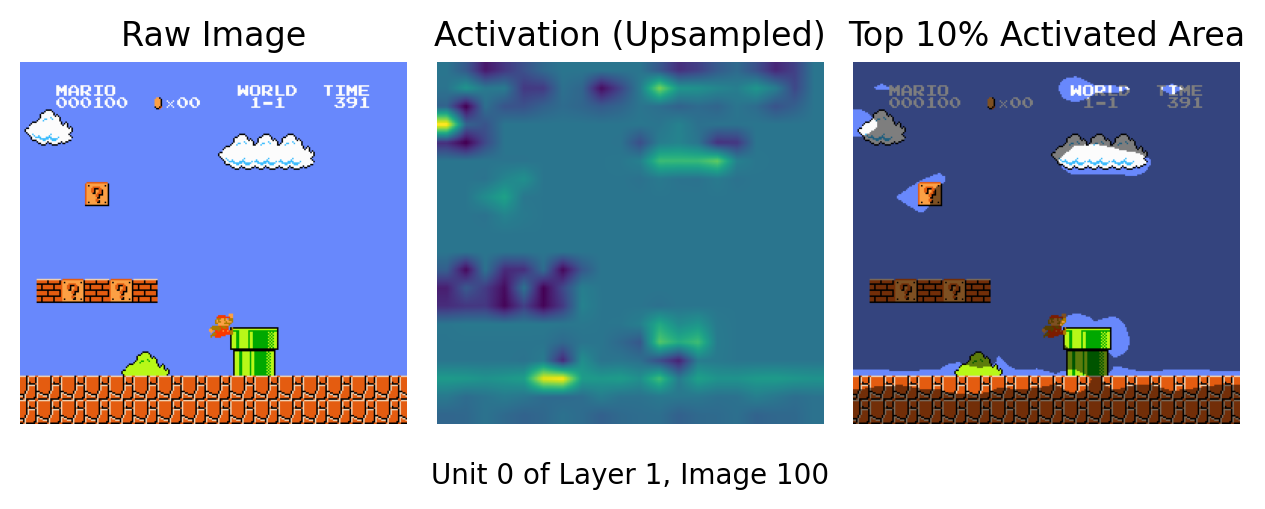

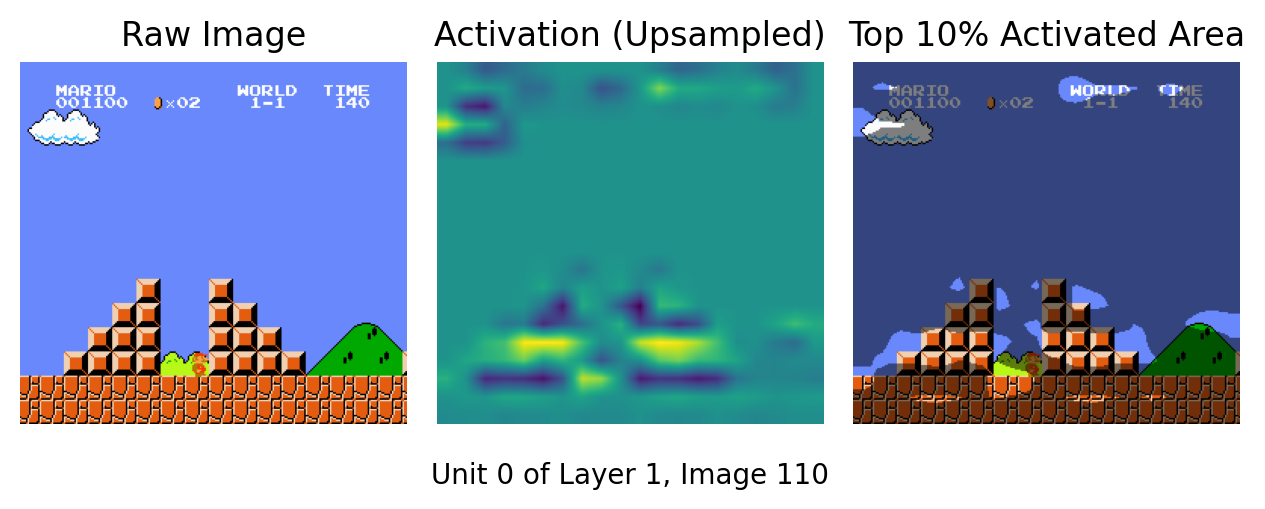

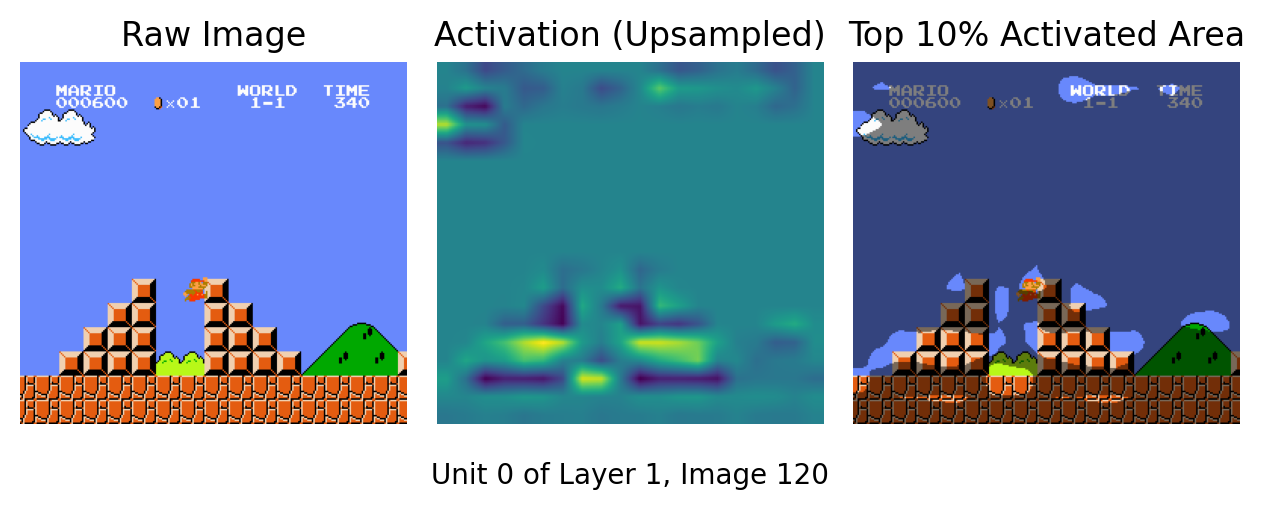

In [10]:
# Same unit, different images
for img_idx in indices:
    viz_activation(model=model, layername='stack.0', unit_idx=0, img_idx=img_idx, quantile=.9)

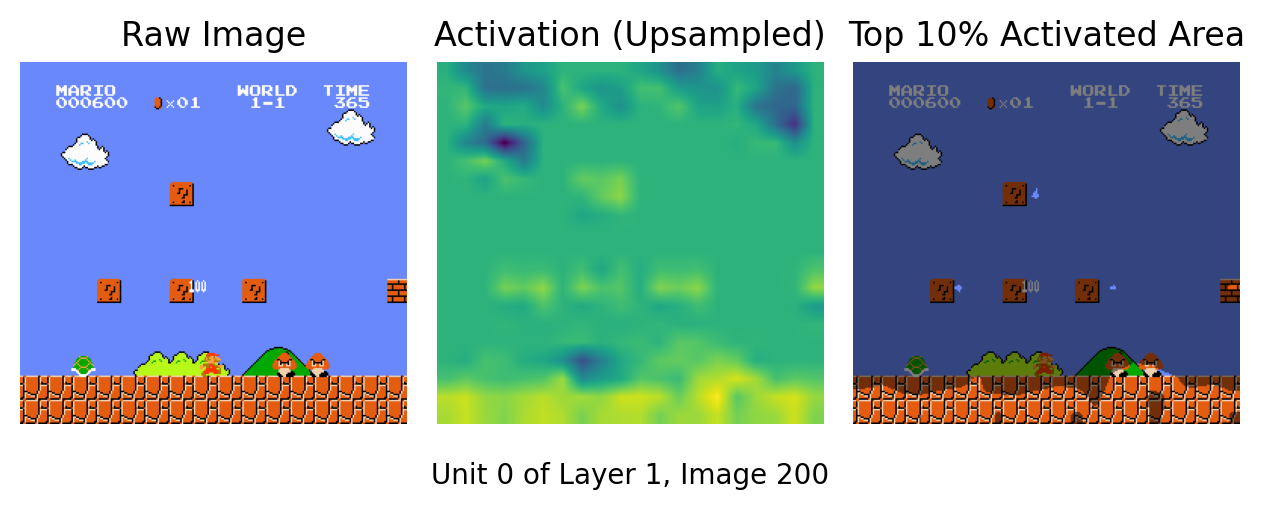

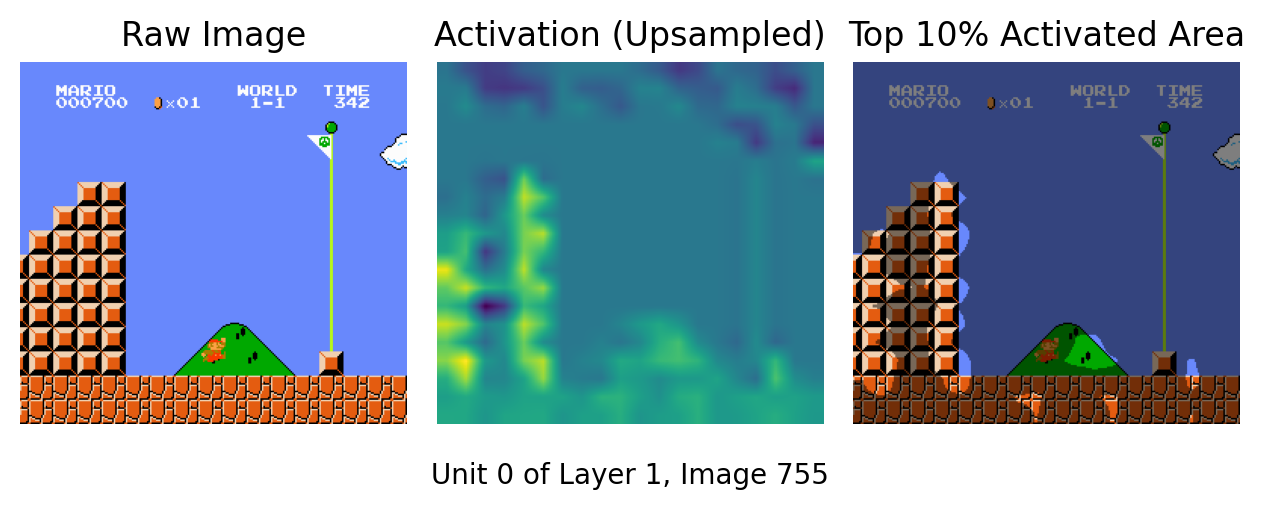

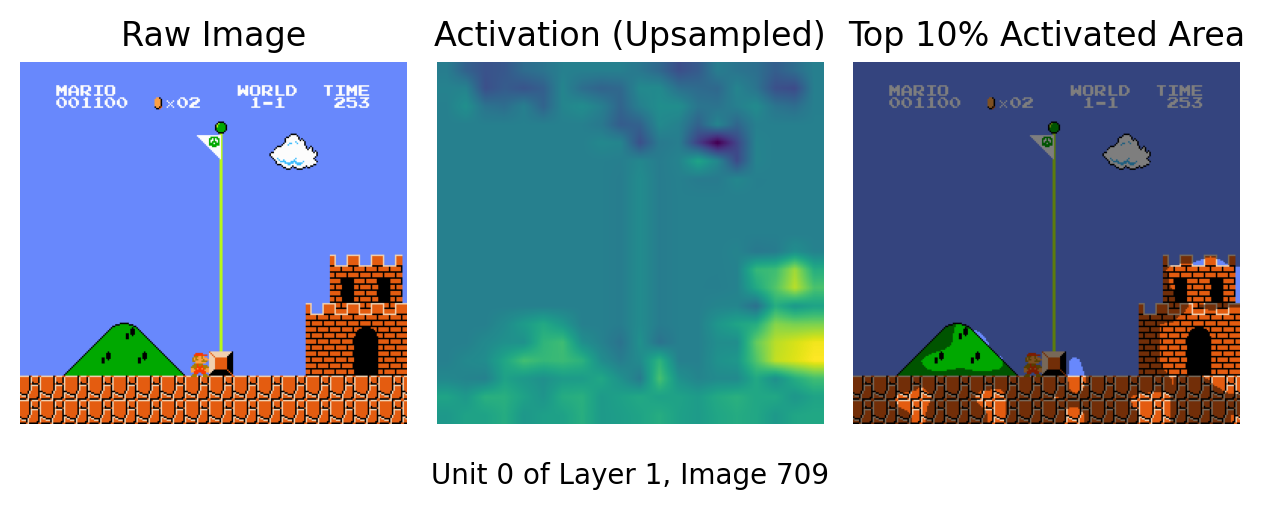

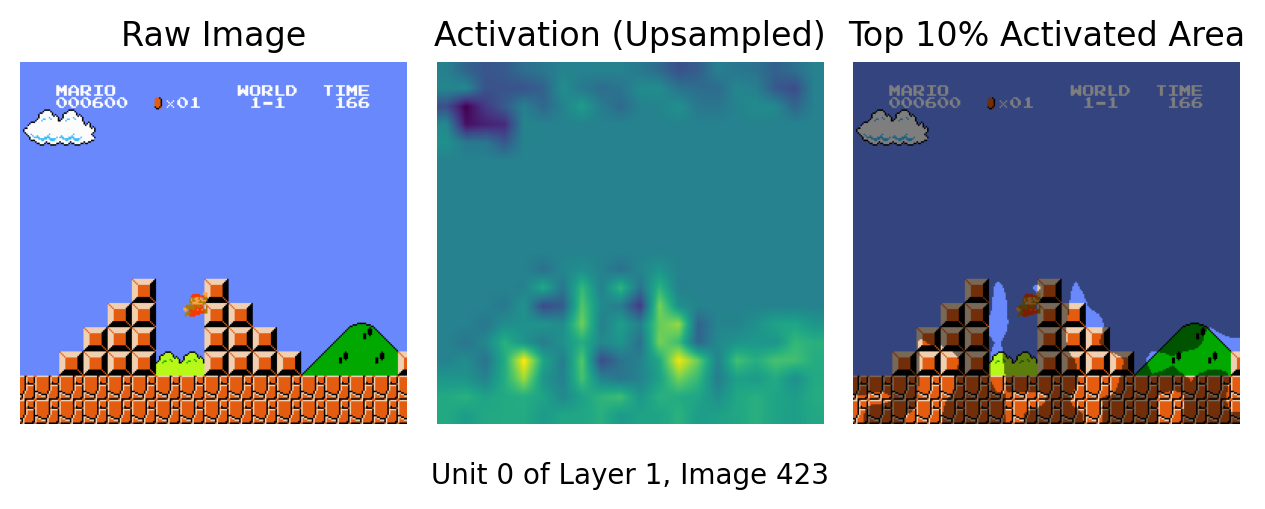

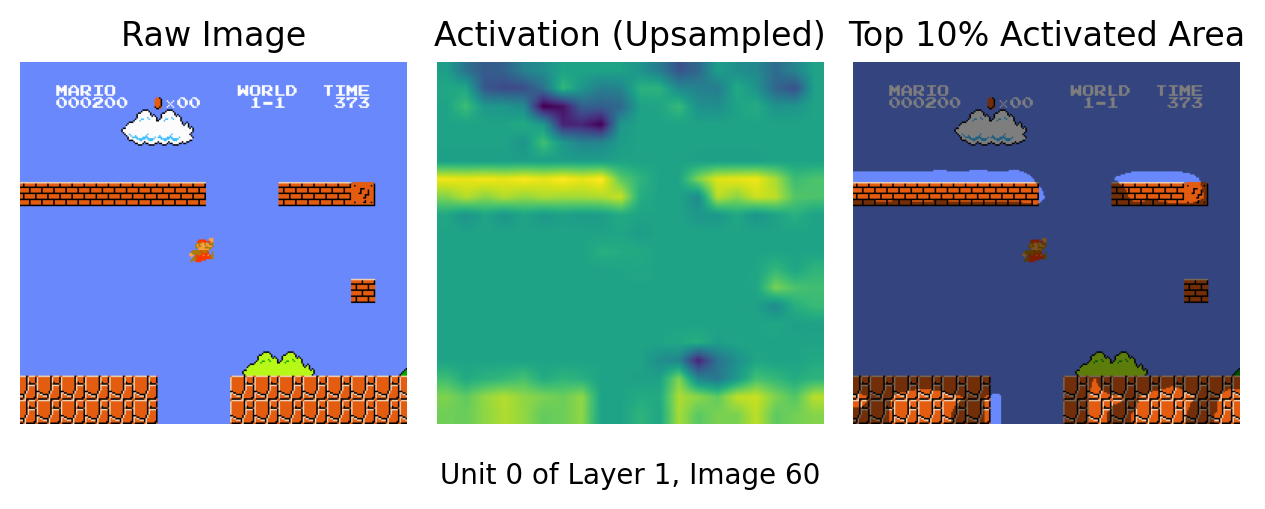

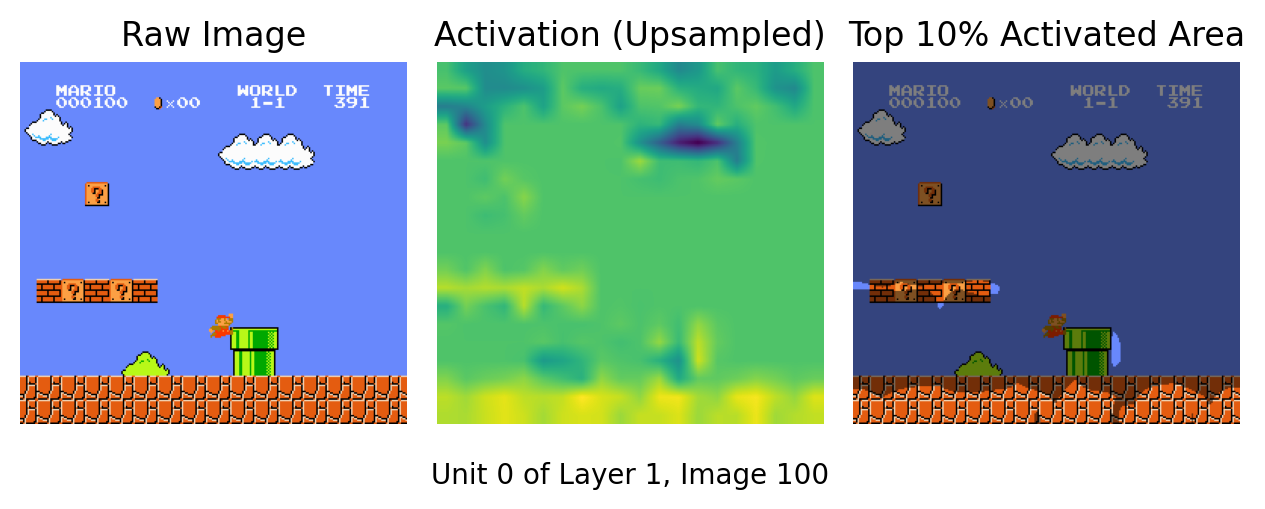

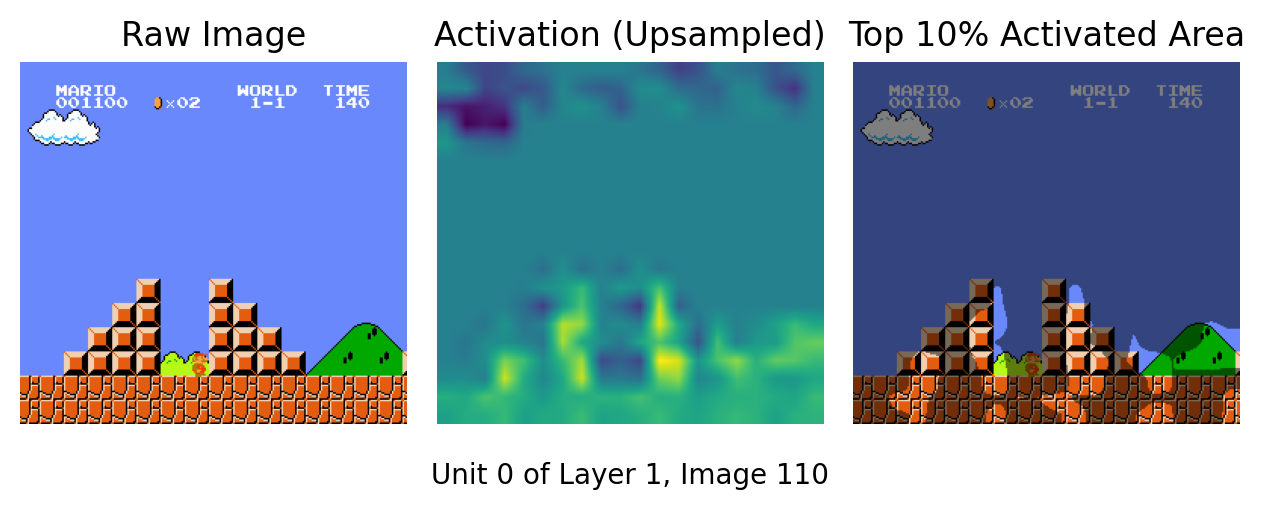

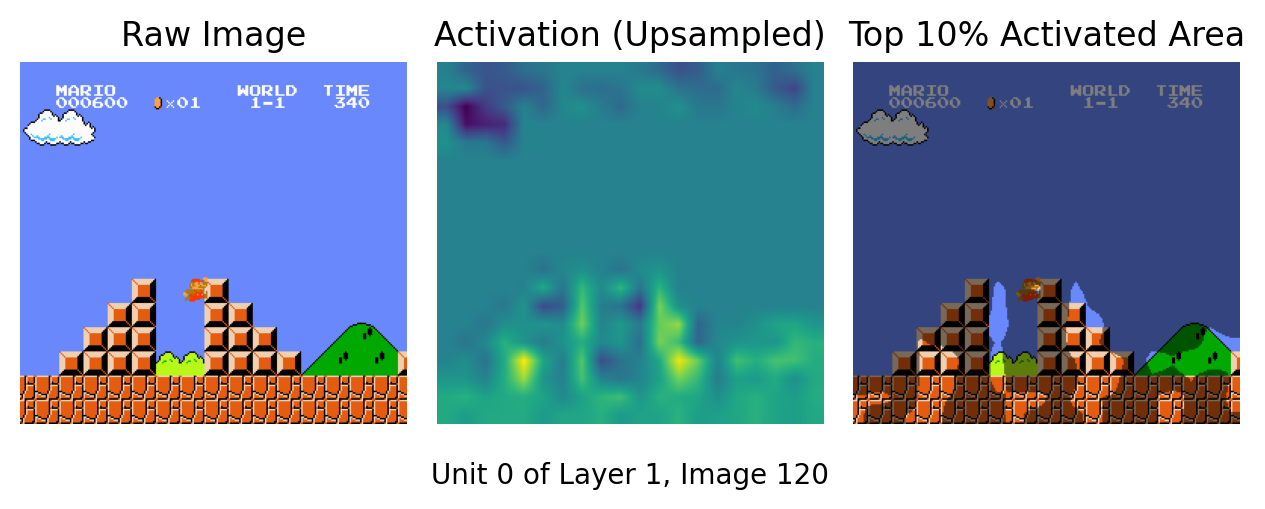

In [11]:
# Compare with a random model
for img_idx in indices:
    viz_activation(model=random_model, layername='stack.0', unit_idx=0, img_idx=img_idx, quantile=.9)

## Calculation of IoU

$$IoU = \frac{area\, of\, (highly\, activated\, region\, \cap\, semantic\, region)}{area\, of\, (highly\, activated\, region\, \cup\, semantic\, region)}$$

Highly activated region by a single input for a single unit is defined as follows.

- The inspected target is this single unit, designated by $u$.
- Given a single input image $x$, the activation map at the original resolution can be acquired through retaining and bilinear resampling.
- For a dataset, an activation threshold $t_{u}$ can be calculated, so that $$P[a_{x,p}(u) \geq t_{u}] \leq P^{*}$$, where $P^{*}$ is a possibility value, typically 0.05 or 0.01, and $a_{x,p}$ is the resampled activation value at pixel $p$ within input image $x$.
- Highly activated region within input image $x$ for unit $u$ is $$\{ p \in x | a_{x,p}(u) \geq t_{u} \}$$

The semantic region of a concept for the input image is simply the pixels at which the 2-D binary mask generated by feeding the image to the segmentation model is 1: $$\{ p \in x | segm_{x}(p) = 1 \}$$

The global $IoU$ ratio is the average of all $IoU$ ratios for each input image in the dataset. The higher the global $IoU$ ratio, the more likely the inspected unit $u$ is a "detector" for the given semantic concept.

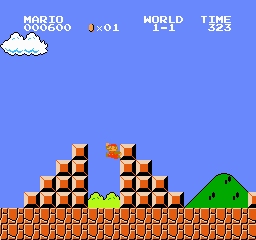

'right-A'

In [12]:
# First, choose the layer to be dissected.
# Only one layer can be dissected at a time.
layername = 'stack.0'
model.retain_layer(layername)

img_idx = 1499
# A feed is provided to give value in the retained layer (used to detect shapes in following steps)
predicted_action = action_from_dqn_output(model(dataset[img_idx][0].cuda()))
test_image = Image.open(dataset.images[img_idx][0])

display(test_image, predicted_action)

In [13]:
# Find t_u for each u in the layer
pbar.descnext('rq')

def resfile(filename):
    return 'results/mydissect/' + filename

upfn = upsample.upsampler(
    (240, 256), source=dataset, data_shape=model.retained_layer(layername).shape[2:]
)
    

def compute_samples(batch, *args):
    image_batch = batch.cuda()
    _ = model(image_batch)
    acts = model.retained_layer(layername)
    hacts = upfn(acts)
    return hacts.permute(0, 2, 3, 1).contiguous().view(-1, acts.shape[1])

rq = tally.tally_quantile(compute_samples, dataset,
                          sample_size=len(dataset),
                          r=8192,
                          num_workers=4,
                          pin_memory=True,
                          cachefile=resfile('rq.npz'))

Loading cached results/mydissect/rq.npz


In [14]:
# Find from which input images t_u is calculated
pbar.descnext('topk')
def compute_image_max(batch, *args):
    image_batch = batch.cuda()
    _ = model(image_batch)
    acts = model.retained_layer(layername)
    acts = acts.view(acts.shape[0], acts.shape[1], -1)
    acts = acts.max(2)[0]
    return acts
topk = tally.tally_topk(compute_image_max, dataset, sample_size=len(dataset),
        batch_size=50, num_workers=4, pin_memory=True,
        cachefile=resfile('topk.npz'))

Loading cached results/mydissect/topk.npz


In [15]:
# Calculate these most activating images for visualization
pbar.descnext('unit_images')

iv = imgviz.ImageVisualizer((240, 256), source=dataset, quantiles=rq,
        level=rq.quantiles(0.95))
def compute_acts(image_batch, *args):
    image_batch = image_batch.cuda()
    _ = model(image_batch)
    acts_batch = model.retained_layer(layername)
    return acts_batch
unit_images = iv.masked_images_for_topk(
        compute_acts, dataset, topk, k=5, num_workers=4, pin_memory=True,
        cachefile=resfile('top5images.npz'))

Loading cached results/mydissect/top5images.npz


unit 0


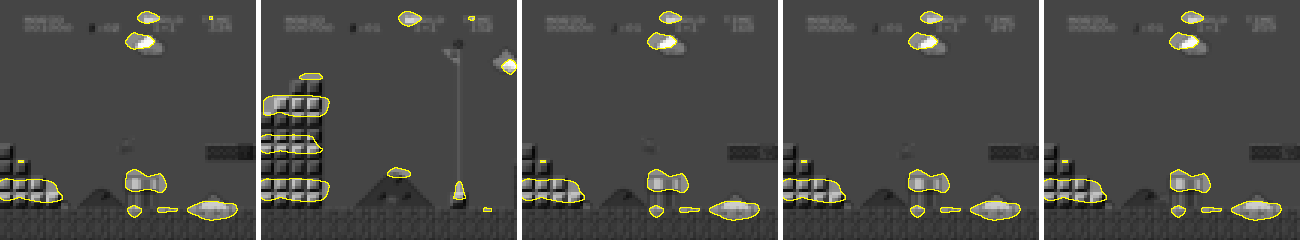

In [16]:
u = 0 # provide unit index here
print('unit %d' % u)
display(unit_images[u])

In [17]:
"""
Calculate global IoUs.
As the choice of P* is rather arbitrary, we can simply inspect
the unit with the highest global IoU within each layer.
"""

level_at_95 = rq.quantiles(.95).cuda()[None,:,None,None]
def compute_conditional_indicator(batch, *args):
    # batch is indices
    batch_data = torch.stack([dataset[i][0] for i in batch], dim=0).cuda()
    to_tensor = T.ToTensor()
    image_batch = [dataset.images[i][0] for i in batch]
    image_batch = torch.stack([to_tensor(Image.open(s)) for s in image_batch], dim=0)
    seg = segmodel(image_batch.cuda())
    _ = model(batch_data)
    acts = model.retained_layer(layername)
    hacts = upfn(acts)
    iacts = (hacts > level_at_95).float() # indicator
    return tally.conditional_samples(iacts, seg)
pbar.descnext('condi95')
condi95 = tally.tally_conditional_mean(compute_conditional_indicator,
        range(len(dataset)), sample_size=len(dataset),
        num_workers=4, pin_memory=True,
        cachefile=resfile('condi95.npz'))

iou_95 = tally.iou_from_conditional_indicator_mean(condi95)
unit_label_95 = [
        (concept.item(), bestiou.item())
        for (bestiou, concept) in zip(*iou_95.max(0))]

Loading cached results/mydissect/condi95.npz


In [18]:
# Get the unit with the biggest IoU, the IoU value, and its corresponding semantic concept indicator
u_max_iou = np.argmax([iou for cls, iou in unit_label_95])
cls_idx, max_iou = unit_label_95[u_max_iou]
print(u_max_iou, max_iou, cls_idx)

11 0.06334681063890457 4


In [19]:
# Another helper function that displays raw image, activations, and segmentations
def raw_act_seg(layername, unit_idx, img_idx, iou=0, path=None):
    model.retain_layer(layername)
    model(dataset[img_idx][0].cuda())
    acts = model.retained_layer(layername)
    a = acts[0][unit_idx].unsqueeze(0)
    upsampled_a = T.Resize((240, 256), antialias=True)(a)[0]

    fig, ((ax2, ax1), (ax3, ax4)) = plt.subplots(2, 2)
    ax1.imshow(upsampled_a.cpu())
    ax1.axis('off')
    img = Image.open(dataset.images[img_idx][0])
    ax2.imshow(img)
    ax2.axis('off')

    upsampled_a = upsampled_a.cpu()
    quantile = np.quantile(upsampled_a.numpy(), .9)
    mask = np.ma.masked_where(upsampled_a.numpy() > quantile, upsampled_a)
    image_arr = np.array(img)
    masked = np.copy(image_arr)
    masked[mask.mask] = image_arr[mask.mask]
    masked[~mask.mask] = image_arr[~mask.mask] * 0.5

    ax3.imshow(masked)
    ax3.axis('off')

    segm = segmodel(img, numpy=True).squeeze(0)
    rgb_segm = decode_segmap(segm)
    ax4.axis('off')
    ax4.imshow(rgb_segm)

    text = f'IoU = {iou}'
    fig.text(0.5, 1., text, ha='center')
    plt.tight_layout()
    if path:
        plt.savefig(path, bbox_inches='tight')
    plt.show()

You can see that unit 11 at the first convolutional layer is highly activated by "bricks", "floors" as well as "bushes" in the background. You can compare it with the same unit from a random model:

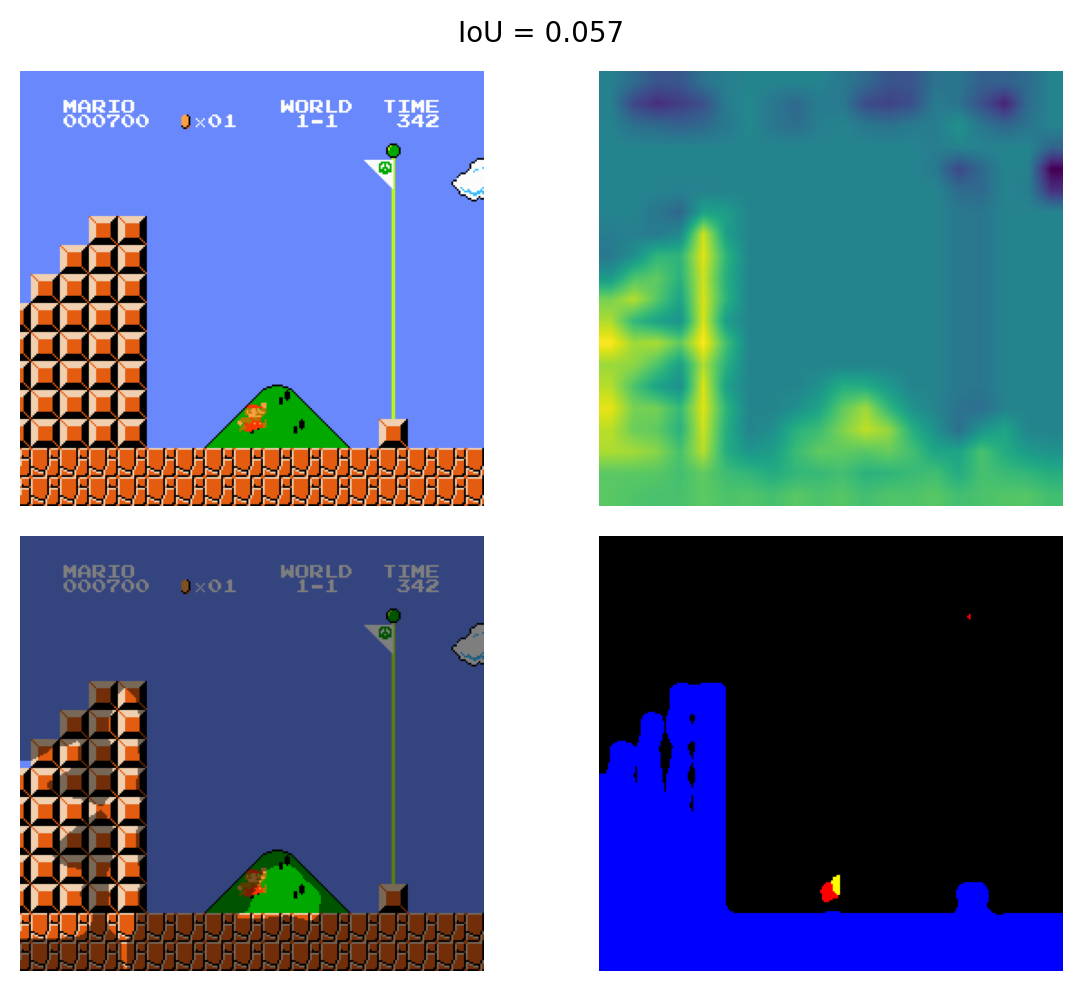

In [20]:
# Play around with the found unit.
img_idx = 755
raw_act_seg('stack.0', 11, img_idx, iou=0.057)

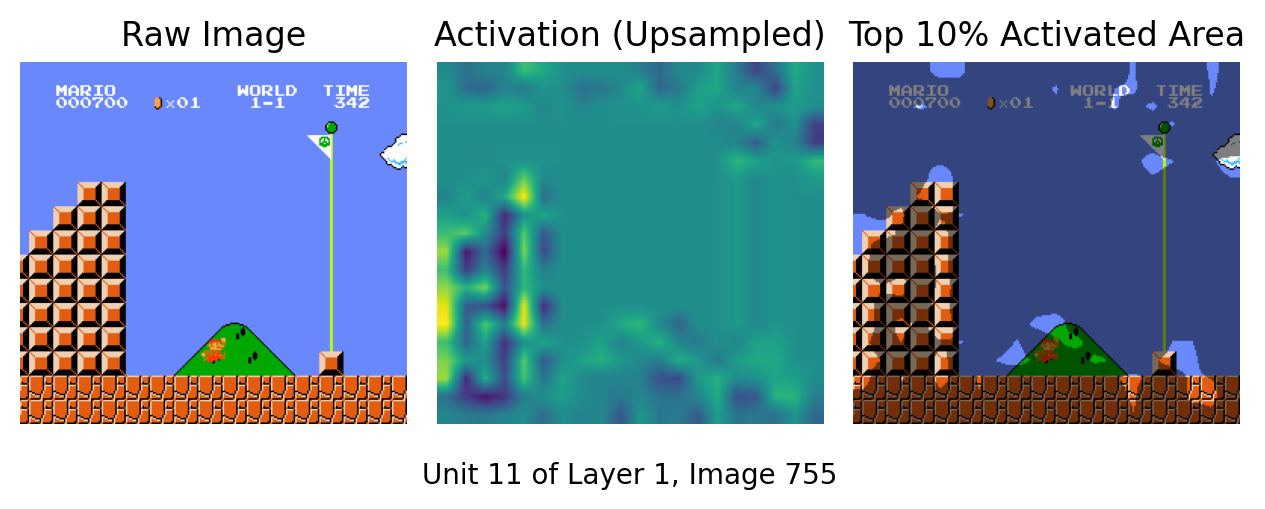

In [21]:
viz_activation(model=random_model, layername='stack.0', unit_idx=11, img_idx=img_idx, quantile=.9)

Compared with the random model, some noises are depressed, and the activation at the corresponding area are strengthened. However, the unit also gains unwanted focus at the "bush" area.

To dissect the other 2 convolutional layers, change `layername` to `stack.2` and `stack.4` and re-run the cells in the 'Calculation of IoU' section.

**Note:** For each layer, remember to change the names of the `.npz` cache files to prevent re-calculating.